In [43]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [44]:
data = pd.read_csv('data_preprocess.csv')

In [45]:
data.head()

time                                               text  \
0  2024-07-22 23:50:08  On Qingdao Zhongshan Road, a silver-gray drive...   
1  2024-07-22 23:49:54  On Qingdao Zhongshan Road, a silver-gray drive...   
2  2024-07-22 23:44:34  @elonmusk Brother Ma, does your Tesla driverle...   
3  2024-07-22 21:06:00  @visualfeastwang Wow, Driverless car_ China is...   
4  2024-07-22 21:04:25  @Kling_ai Translation: In 2028, the driverless...   

                                      processed_text  textblob_score  \
0  qingdao zhongshan road silvergray driverless c...       -0.050000   
1  qingdao zhongshan road silvergray driverless c...       -0.050000   
2  brother tesla driverless car support core paym...        0.000000   
3  wow driverless car china work next level aur y...        0.050000   
4  translation driverless car enter united state ...        0.104167   

  textblob_label  VADER_score VADER_label  combined_score     label  split  
0        neutral       0.0000     neutral       -0.025000   neutral   test  
1        neutral       0.0000     neutral       -0.025000   neutral  train  
2        neutral       0.4019    positive        0.200950  positive  train  
3        neutral       0.8126    positive        0.431300  positive  train  
4       positive       0.0258     neutral        0.064983   neutral  train

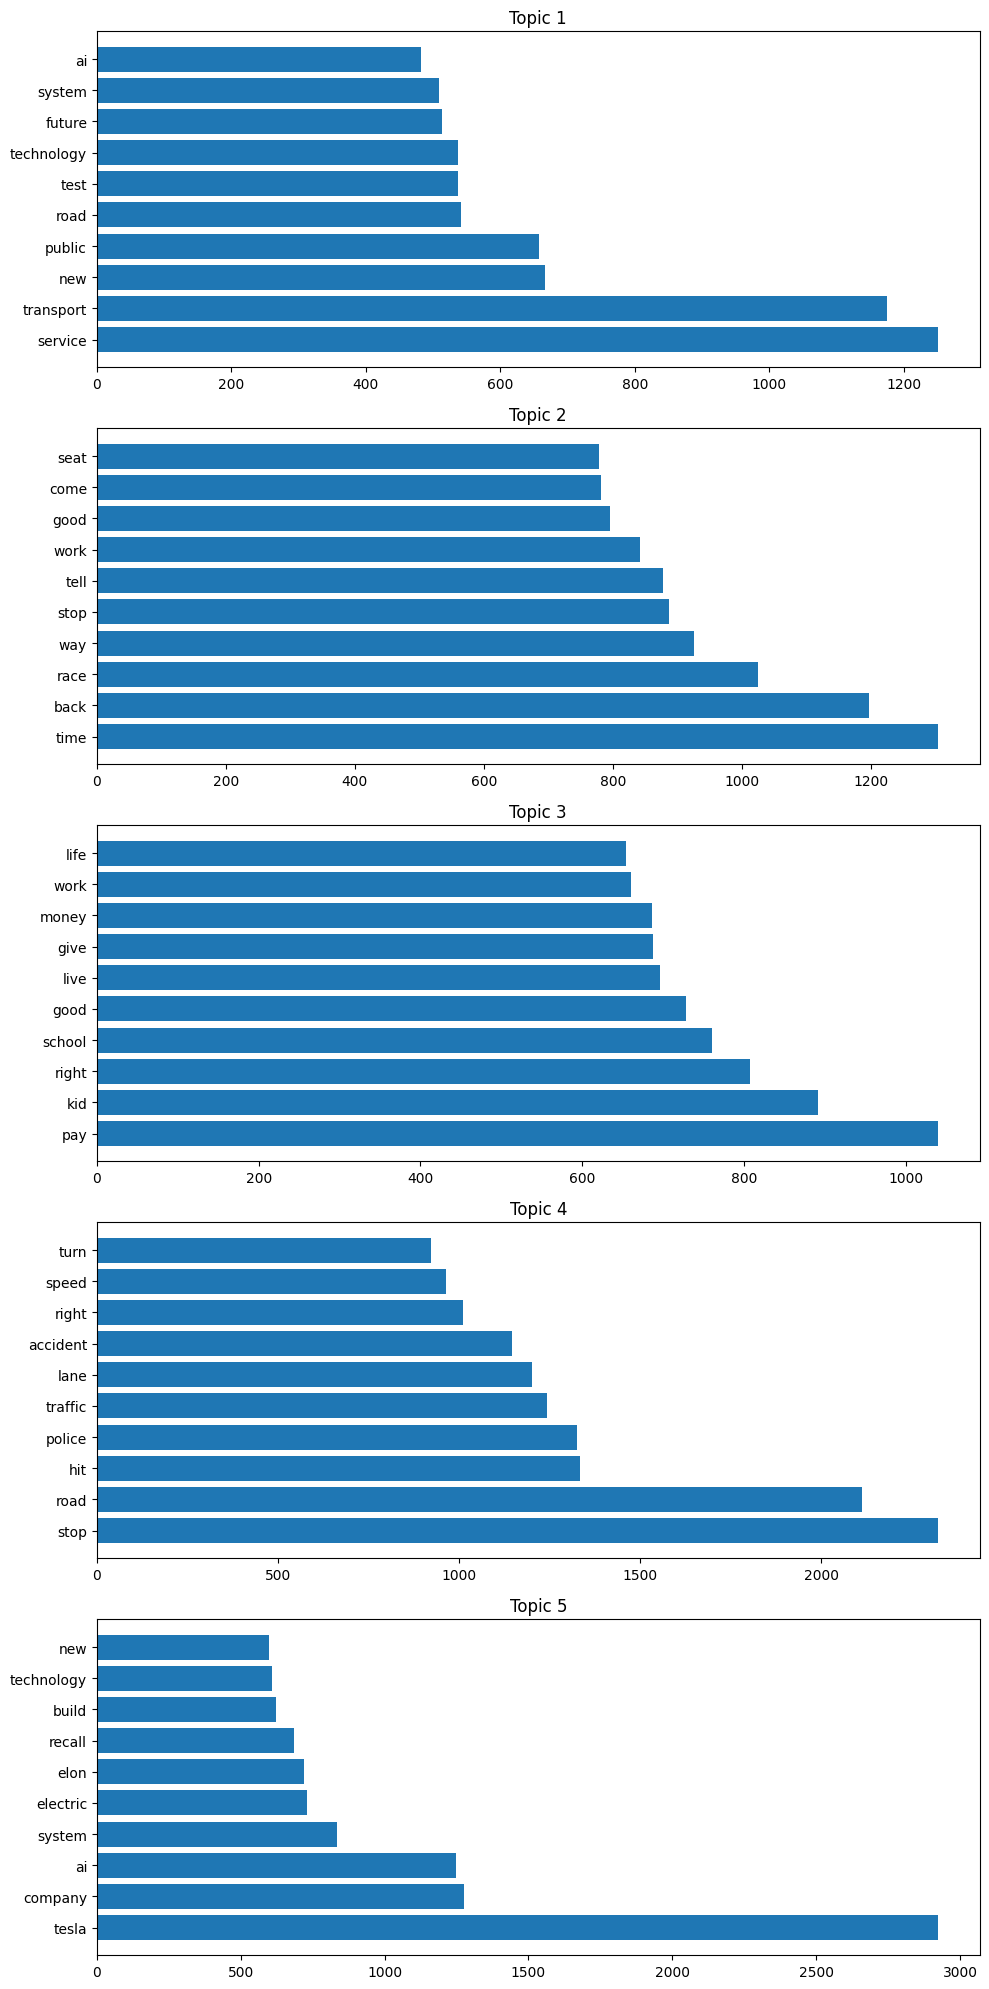

In [46]:
# Custom stop words list
custom_stop_words = set([
    "amp", "car", "drive", "driver", "bus", "say", "day", 
    "make", "know", "think", "people", "human", "autonomous", 
    "vehicle", "use", "selfdriving", "im", "robot", "self",
    "like", "driveless","truck","get","go","one","see","would",
    "want","driverless","fsd","even","without","us","year","need",
    "also","take","thing","really","automate","full","could"
])

# Convert combined_stop_words to a list
combined_stop_words = list(custom_stop_words)

# Step 1: Vectorize the processed_text column with custom stop words
vectorizer = CountVectorizer(max_features=5000, stop_words=combined_stop_words)
text = data['processed_text'].dropna()  # Ensure no missing values
text_matrix = vectorizer.fit_transform(text)

# Step 2: Apply LDA for topic modeling
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  
lda_model.fit(text_matrix)

# Extract feature names and topics
feature_names = vectorizer.get_feature_names_out()
topics = lda_model.components_

# Step 3: Visualize the top 10 words for each topic
top_n = 10
topic_keywords = {}
for topic_idx, topic in enumerate(topics):
    top_keywords = [(feature_names[i], topic[i]) for i in topic.argsort()[-top_n:]]
    topic_keywords[f"Topic {topic_idx+1}"] = top_keywords

# Prepare visualization
fig, axs = plt.subplots(len(topic_keywords), 1, figsize=(10, 20))
for idx, (topic_name, keywords) in enumerate(topic_keywords.items()):
    words, weights = zip(*keywords)
    axs[idx].barh(words, weights, align='center')
    axs[idx].set_title(topic_name)
    axs[idx].invert_yaxis()

plt.tight_layout()
plt.show()


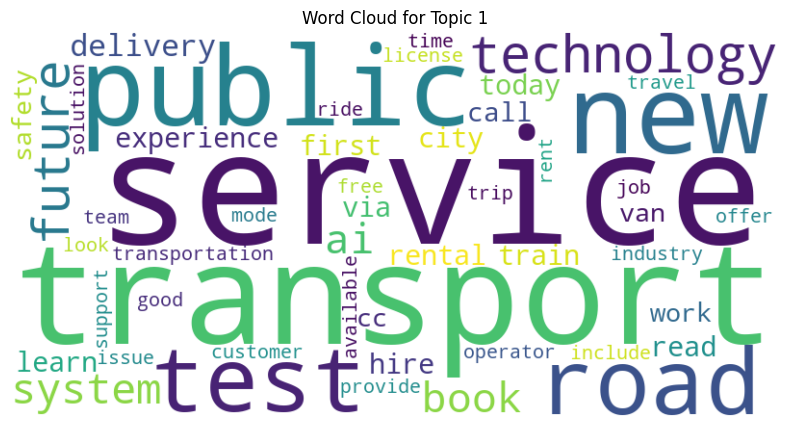

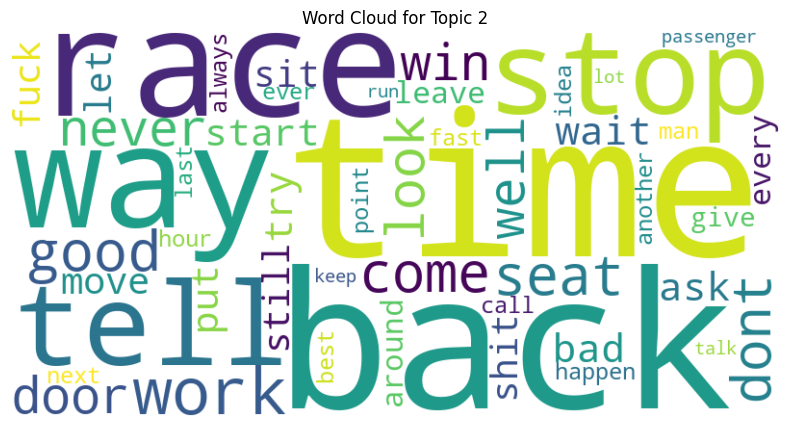

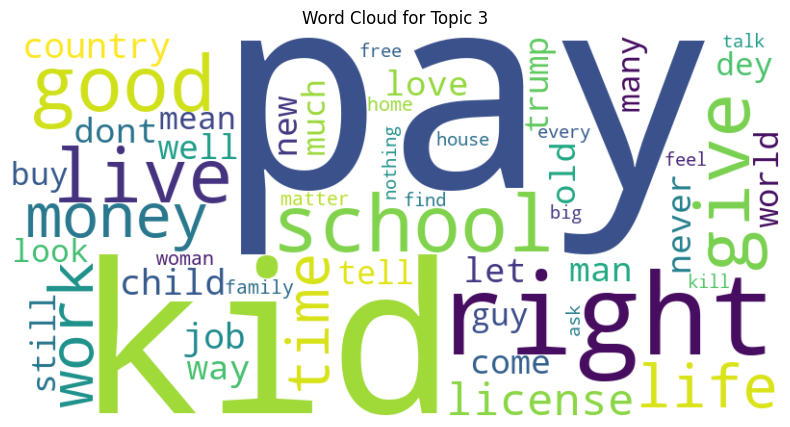

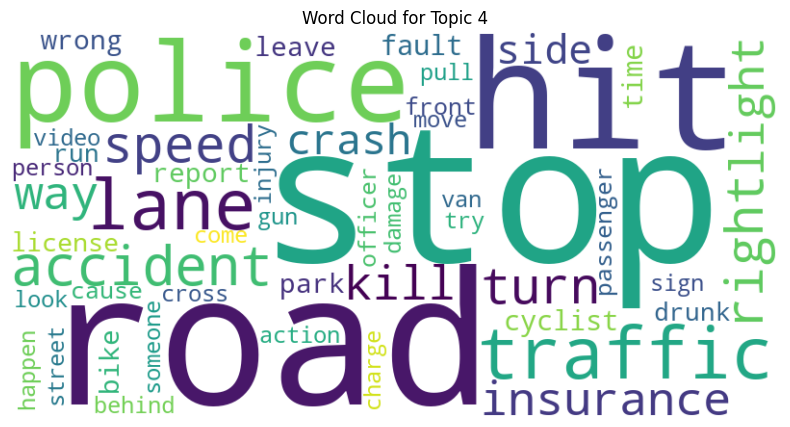

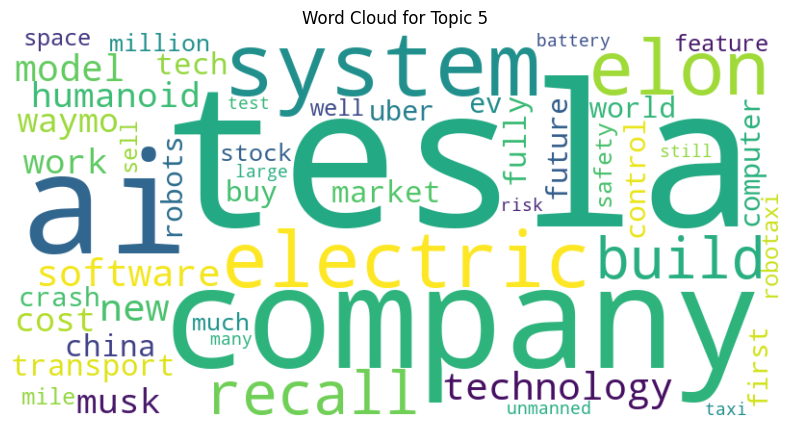

In [47]:
from wordcloud import WordCloud
import numpy as np

data['time'] = pd.to_datetime(data['time'])

data = data[data['time'] >= "2024-06-01"].reset_index(drop=True)

doc_topic_distributions = lda_model.transform(text_matrix)

for topic_idx, topic in enumerate(topics[:5]):  
    word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[-50:]}  
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_idx + 1}")
    plt.show()



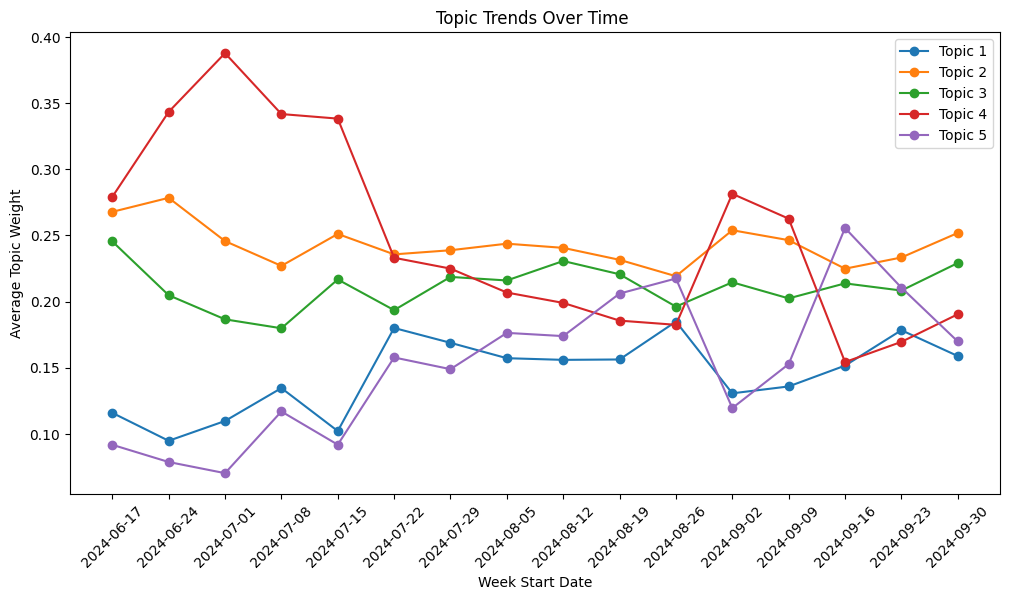

In [48]:
data['week'] = data['time'].dt.to_period('W') 

weekly_topic_distributions = {}
week_start_dates = []  
for week in sorted(data['week'].unique()):
    indices = data.index[data['week'] == week]  
    week_start_dates.append(week.start_time)
    weekly_topic_distributions[week.start_time] = doc_topic_distributions[indices].mean(axis=0)

plt.figure(figsize=(12, 6))
for topic_idx in range(5):  
    topic_trend = [weekly_topic_distributions[week][topic_idx] for week in week_start_dates]
    plt.plot(week_start_dates, topic_trend, marker='o', label=f"Topic {topic_idx + 1}")

plt.title("Topic Trends Over Time ")
plt.xlabel("Week Start Date")
plt.ylabel("Average Topic Weight")
plt.legend()
plt.xticks(week_start_dates, rotation=45)  
plt.show()

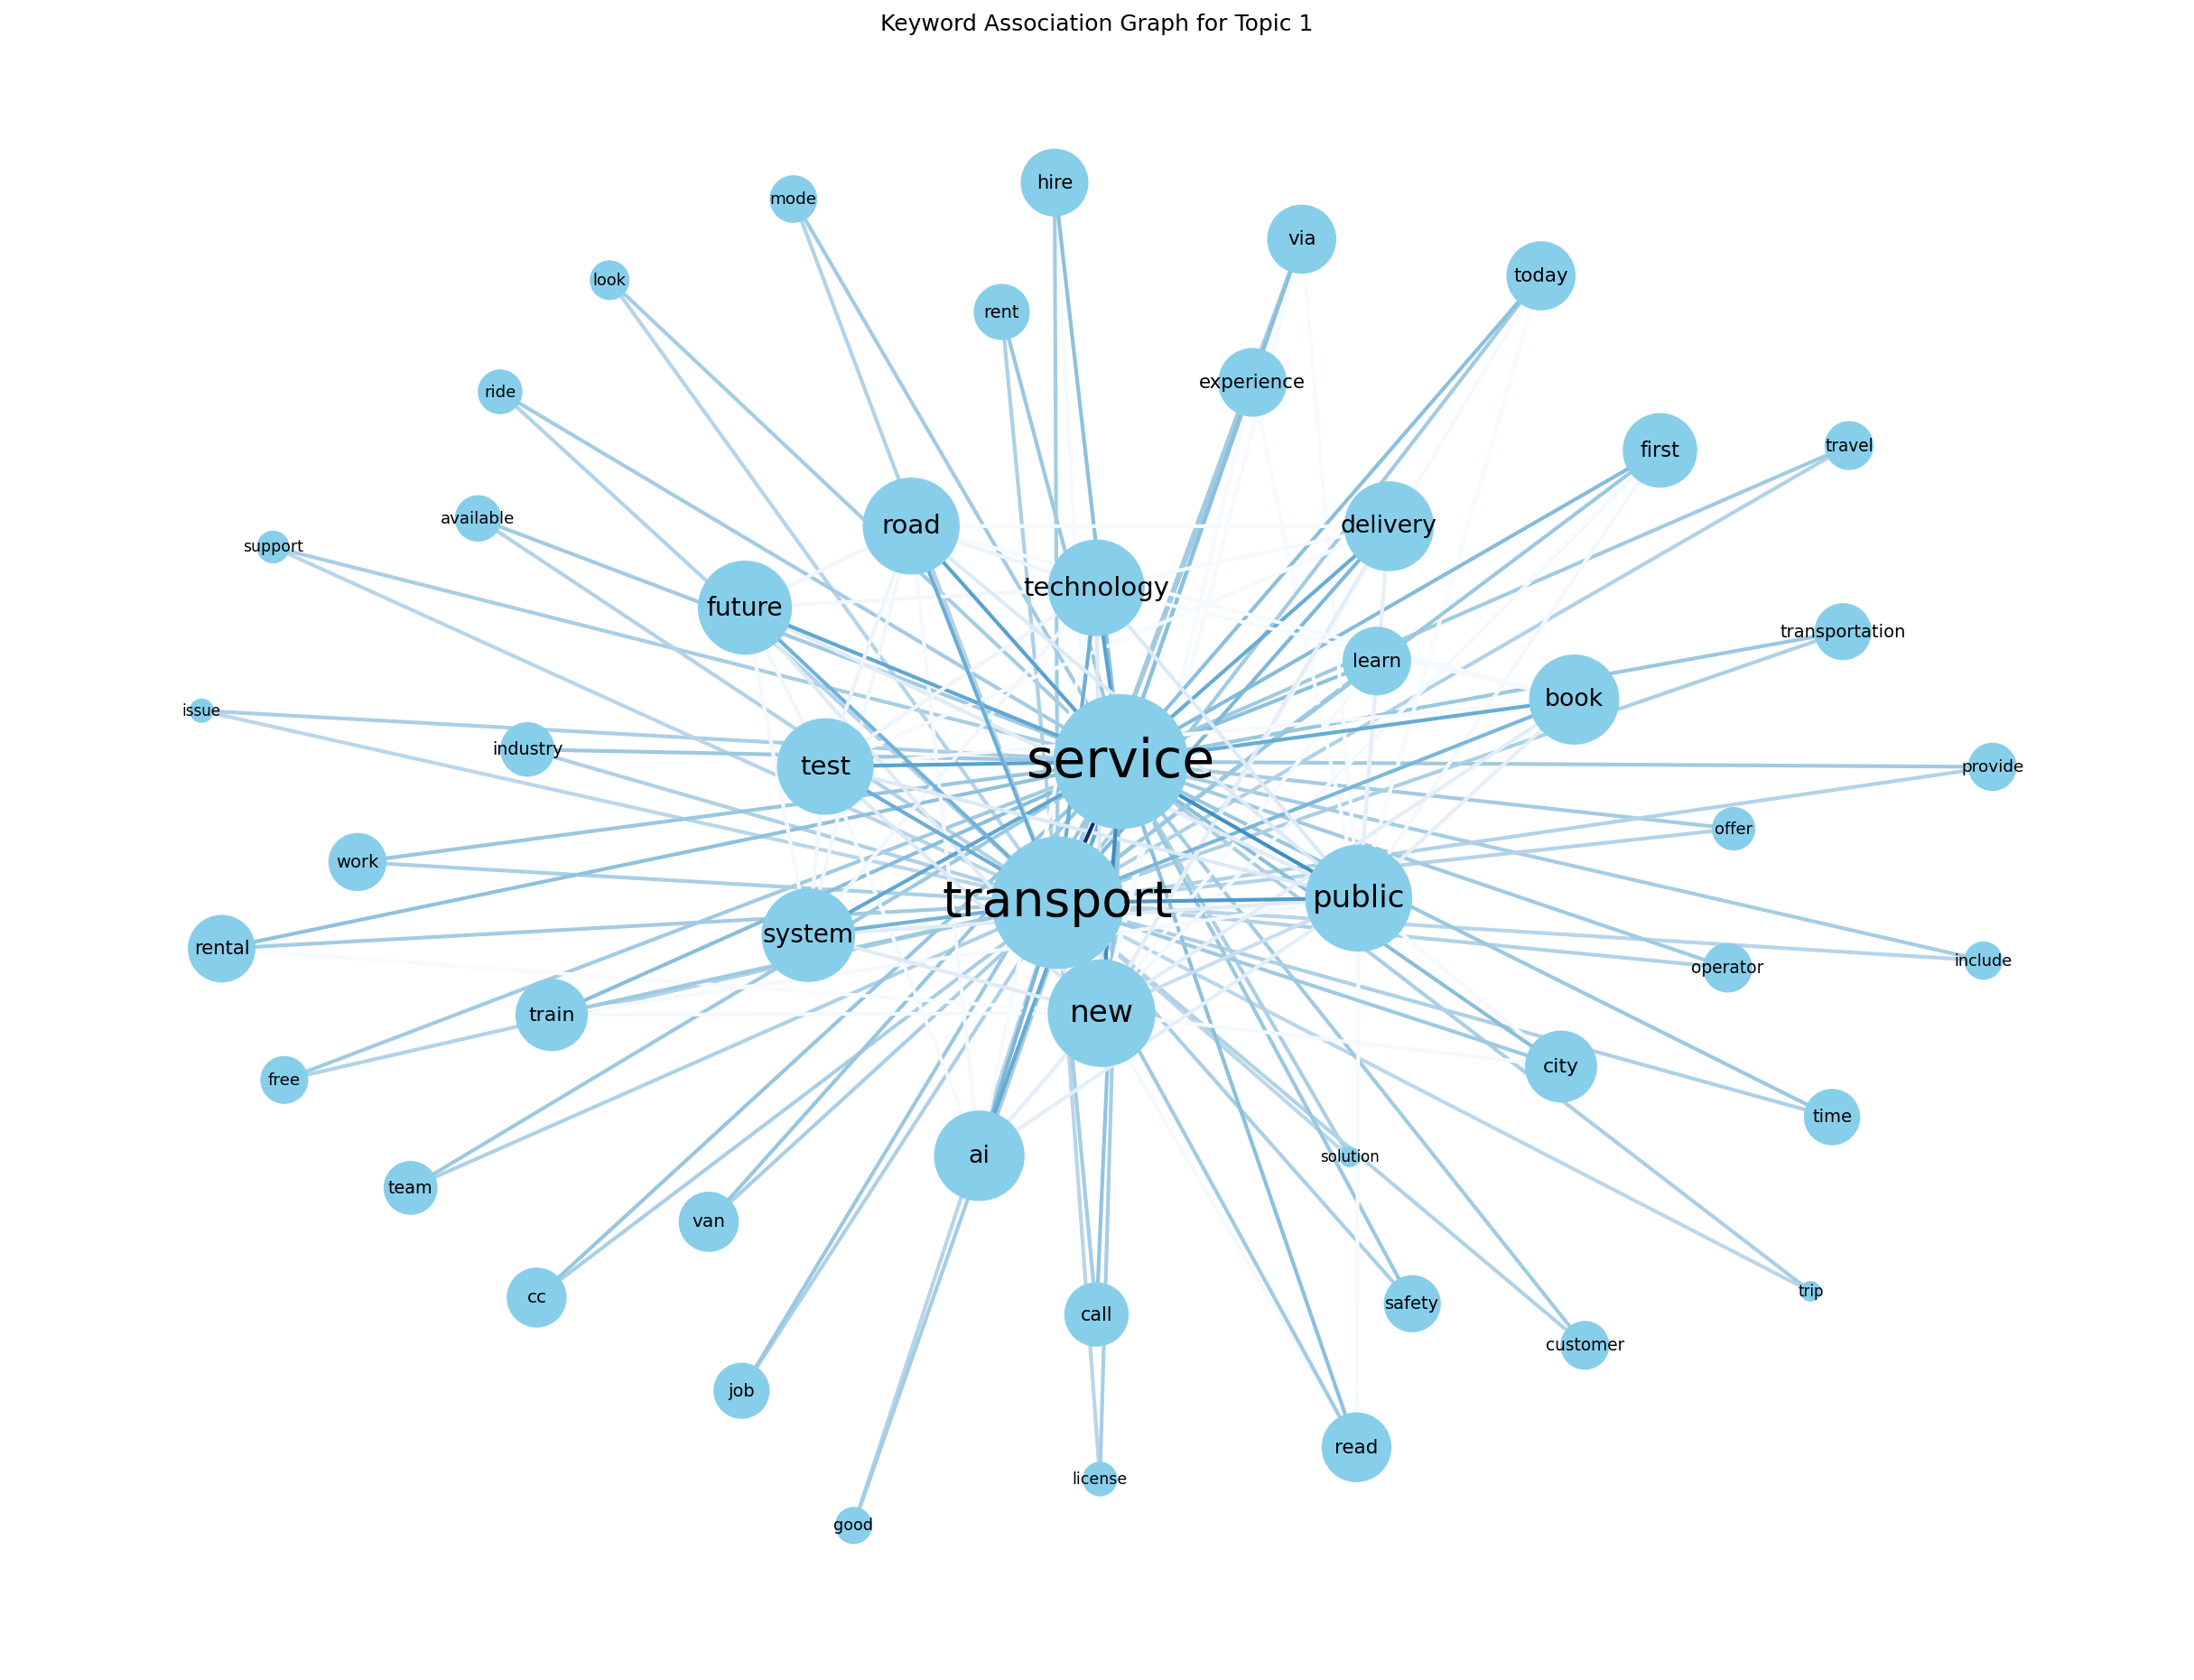

In [49]:
import networkx as nx
from collections import Counter

topic_idx = 0 
top_n = 50
top_keywords = [(feature_names[i], topics[topic_idx][i]) for i in topics[topic_idx].argsort()[-top_n:]]
words, weights = zip(*top_keywords)

G_topic = nx.Graph()

for word, weight in top_keywords:
    G_topic.add_node(word, size=weight)


for i in range(len(words)):
    for j in range(i + 1, len(words)):
        if words[i] != words[j]:
            if G_topic.has_edge(words[i], words[j]):
                G_topic[words[i]][words[j]]['weight'] += 1  
            else:
                G_topic.add_edge(words[i], words[j], weight=(weights[i] + weights[j]) / 2)  

edges_to_draw = [(u, v) for u, v in G_topic.edges() if G_topic[u][v]['weight'] > 500]

plt.figure(figsize=(16, 12), dpi=150)
pos = nx.spring_layout(G_topic, seed=42, k=0.7)  

min_node_size = 100
max_node_size = 5000
log_sizes = [np.log(G_topic.nodes[node]['size'] + 1) for node in G_topic.nodes()]  # 对节点大小取对数
min_log_size = min(log_sizes)
max_log_size = max(log_sizes)

node_sizes = [
    min_node_size + ((log_size - min_log_size) / (max_log_size - min_log_size)) * (max_node_size - min_node_size)
    for log_size in log_sizes
]

edge_weights = [G_topic[u][v]['weight'] for u, v in edges_to_draw]
min_weight = min(edge_weights)
max_weight = max(edge_weights)
edge_colors = [
    plt.cm.Blues((weight - min_weight) / (max_weight - min_weight)) for weight in edge_weights
]

nx.draw(
    G_topic, pos, edgelist=edges_to_draw, with_labels=False, node_color='skyblue',
    edge_color=edge_colors, node_size=node_sizes, width=2
)

font_size_base = 8
font_size_scaling = 20
for node, (x, y) in pos.items():
    node_size = G_topic.nodes[node]['size']
    font_size = font_size_base + ((node_size - min(weights)) / (max(weights) - min(weights))) * font_size_scaling
    plt.text(
        x, y, s=node, fontsize=font_size, color='black',
        horizontalalignment='center', verticalalignment='center'
    )

plt.title("Keyword Association Graph for Topic 1")
plt.show()


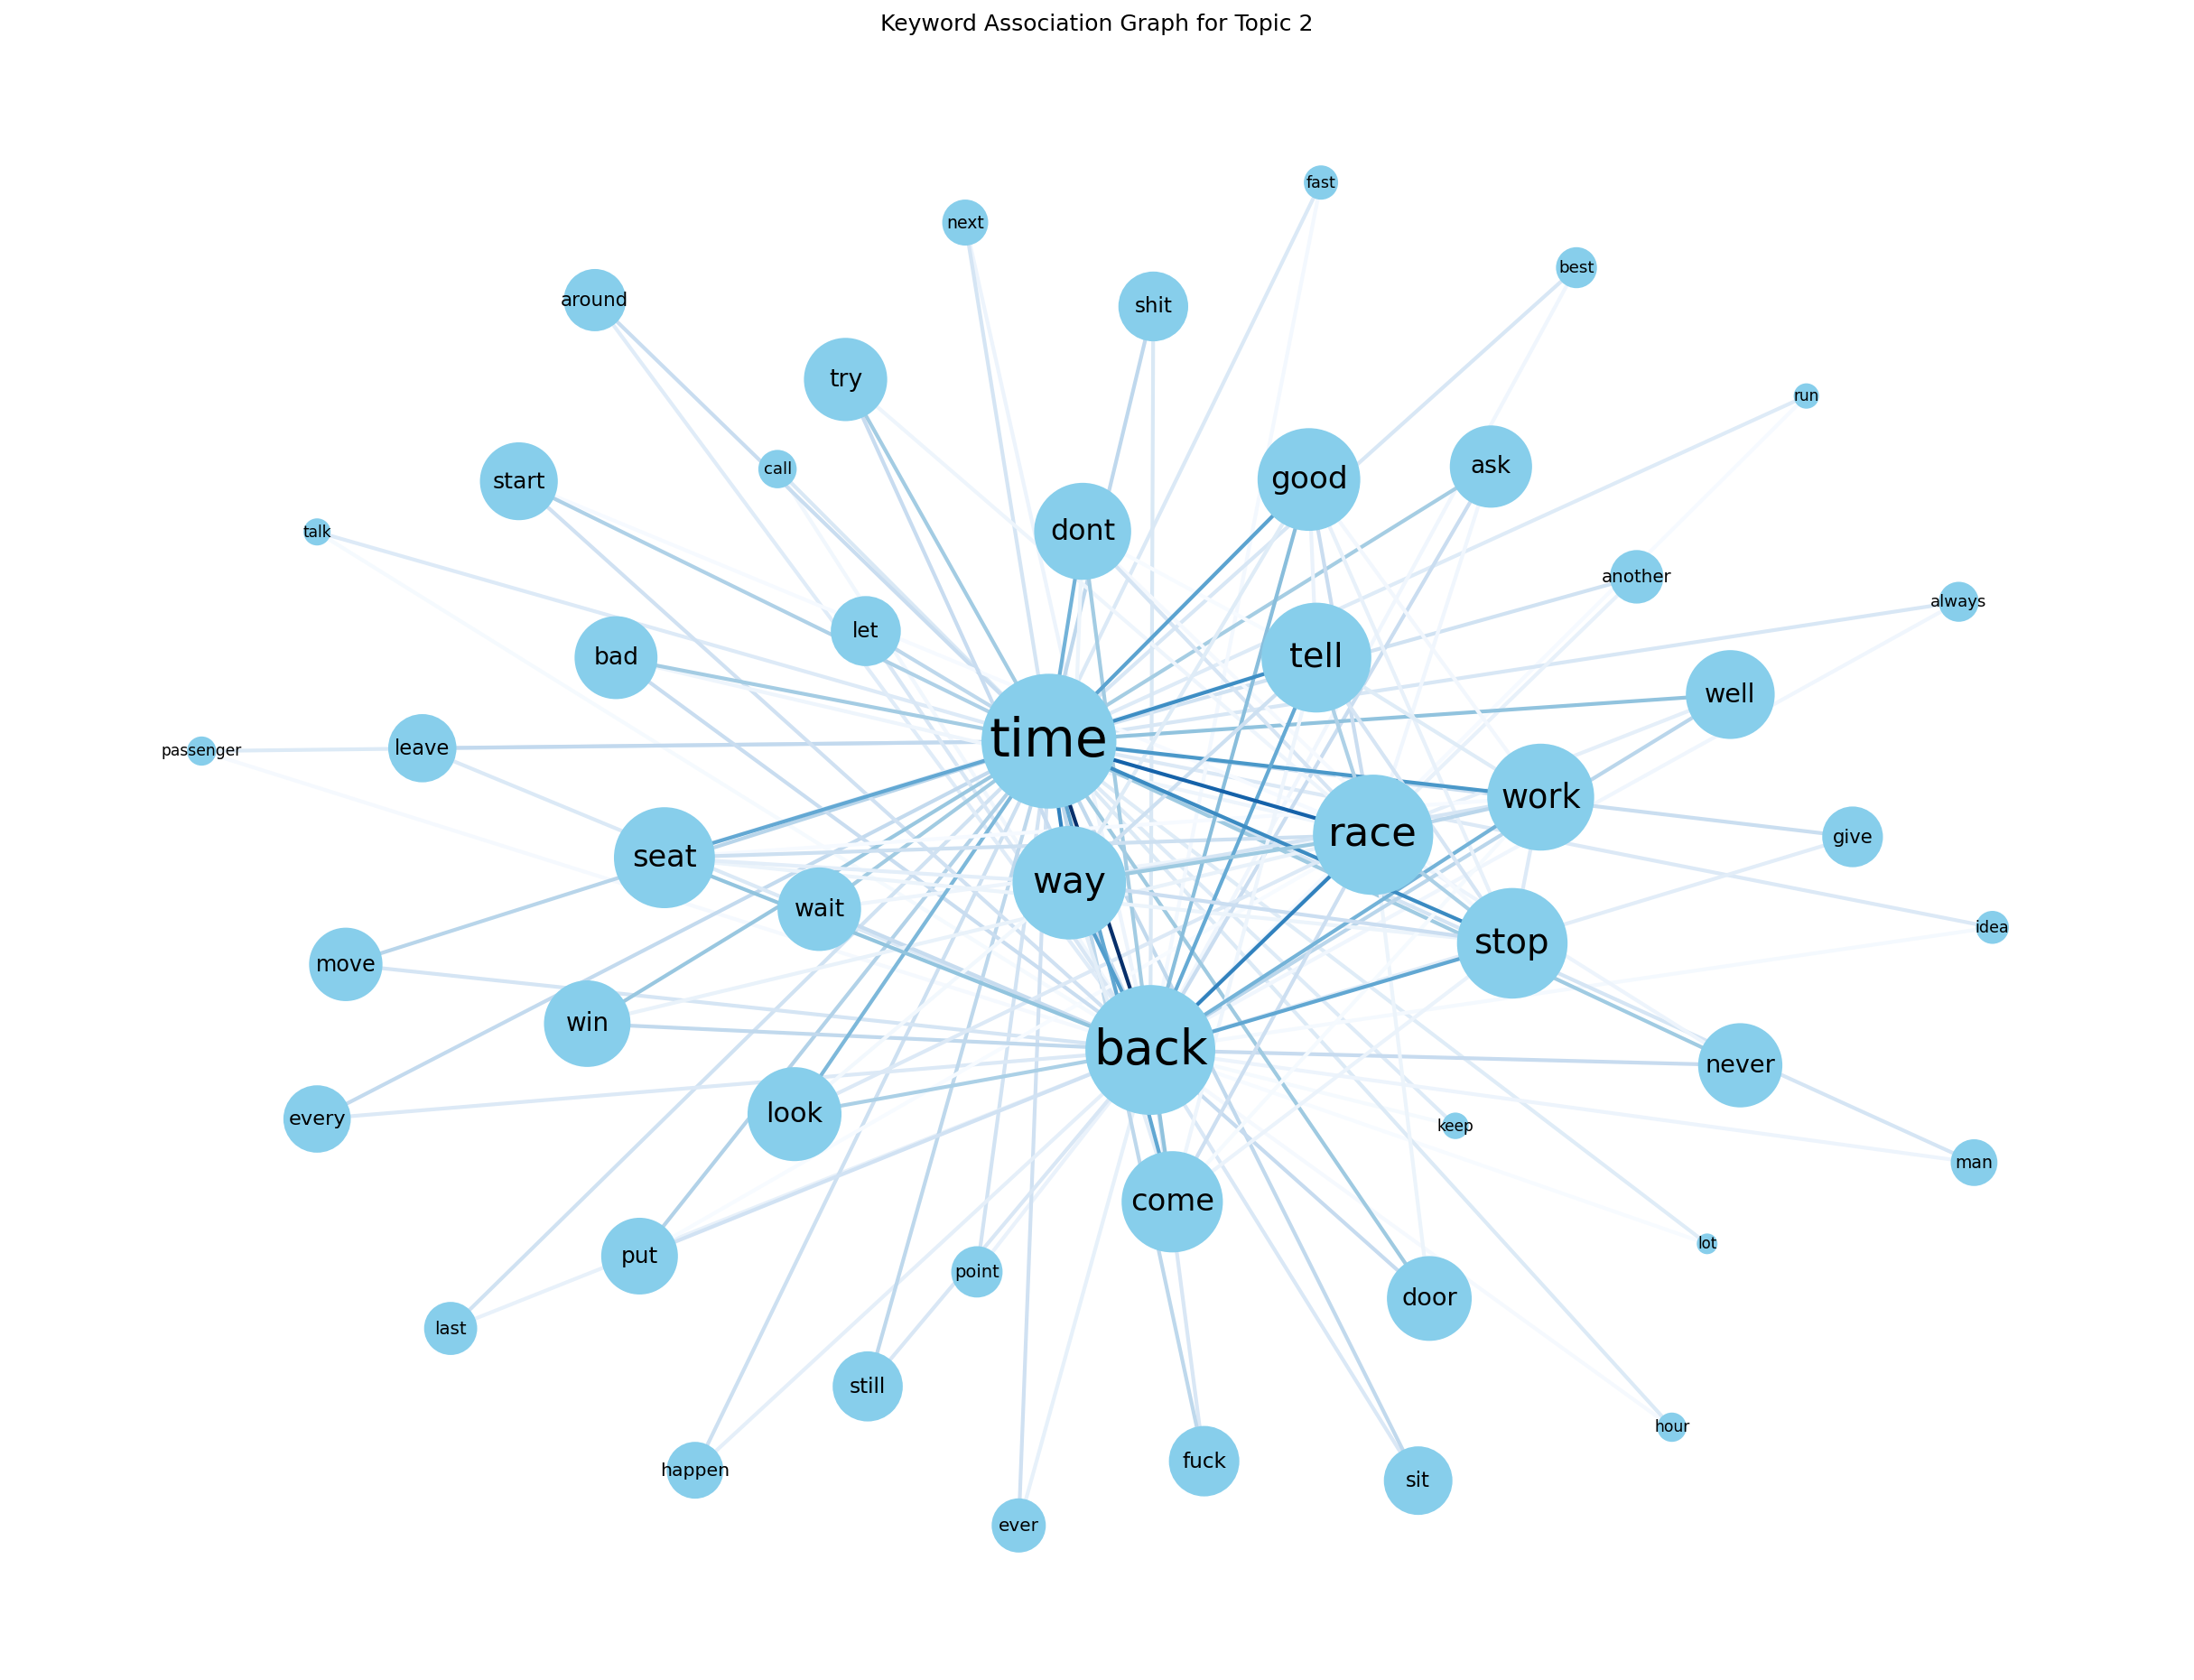

In [50]:
import networkx as nx
from collections import Counter

topic_idx = 1  # Topic 2
top_n = 50
top_keywords = [(feature_names[i], topics[topic_idx][i]) for i in topics[topic_idx].argsort()[-top_n:]]
words, weights = zip(*top_keywords)

G_topic = nx.Graph()

for word, weight in top_keywords:
    G_topic.add_node(word, size=weight)

for i in range(len(words)):
    for j in range(i + 1, len(words)):
        if words[i] != words[j]:
            if G_topic.has_edge(words[i], words[j]):
                G_topic[words[i]][words[j]]['weight'] += 1 
            else:
                G_topic.add_edge(words[i], words[j], weight=(weights[i] + weights[j]) / 2)  

edges_to_draw = [(u, v) for u, v in G_topic.edges() if G_topic[u][v]['weight'] > 800]

plt.figure(figsize=(16, 12), dpi=150)
pos = nx.spring_layout(G_topic, seed=42, k=0.7)  

min_node_size = 100
max_node_size = 5000
log_sizes = [np.log(G_topic.nodes[node]['size'] + 1) for node in G_topic.nodes()]  
min_log_size = min(log_sizes)
max_log_size = max(log_sizes)

node_sizes = [
    min_node_size + ((log_size - min_log_size) / (max_log_size - min_log_size)) * (max_node_size - min_node_size)
    for log_size in log_sizes
]

edge_weights = [G_topic[u][v]['weight'] for u, v in edges_to_draw]
min_weight = min(edge_weights)
max_weight = max(edge_weights)
edge_colors = [
    plt.cm.Blues((weight - min_weight) / (max_weight - min_weight)) for weight in edge_weights
]

nx.draw(
    G_topic, pos, edgelist=edges_to_draw, with_labels=False, node_color='skyblue',
    edge_color=edge_colors, node_size=node_sizes, width=2
)

font_size_base = 8
font_size_scaling = 20
for node, (x, y) in pos.items():
    node_size = G_topic.nodes[node]['size']
    font_size = font_size_base + ((node_size - min(weights)) / (max(weights) - min(weights))) * font_size_scaling
    plt.text(
        x, y, s=node, fontsize=font_size, color='black',
        horizontalalignment='center', verticalalignment='center'
    )

plt.title("Keyword Association Graph for Topic 2")
plt.show()

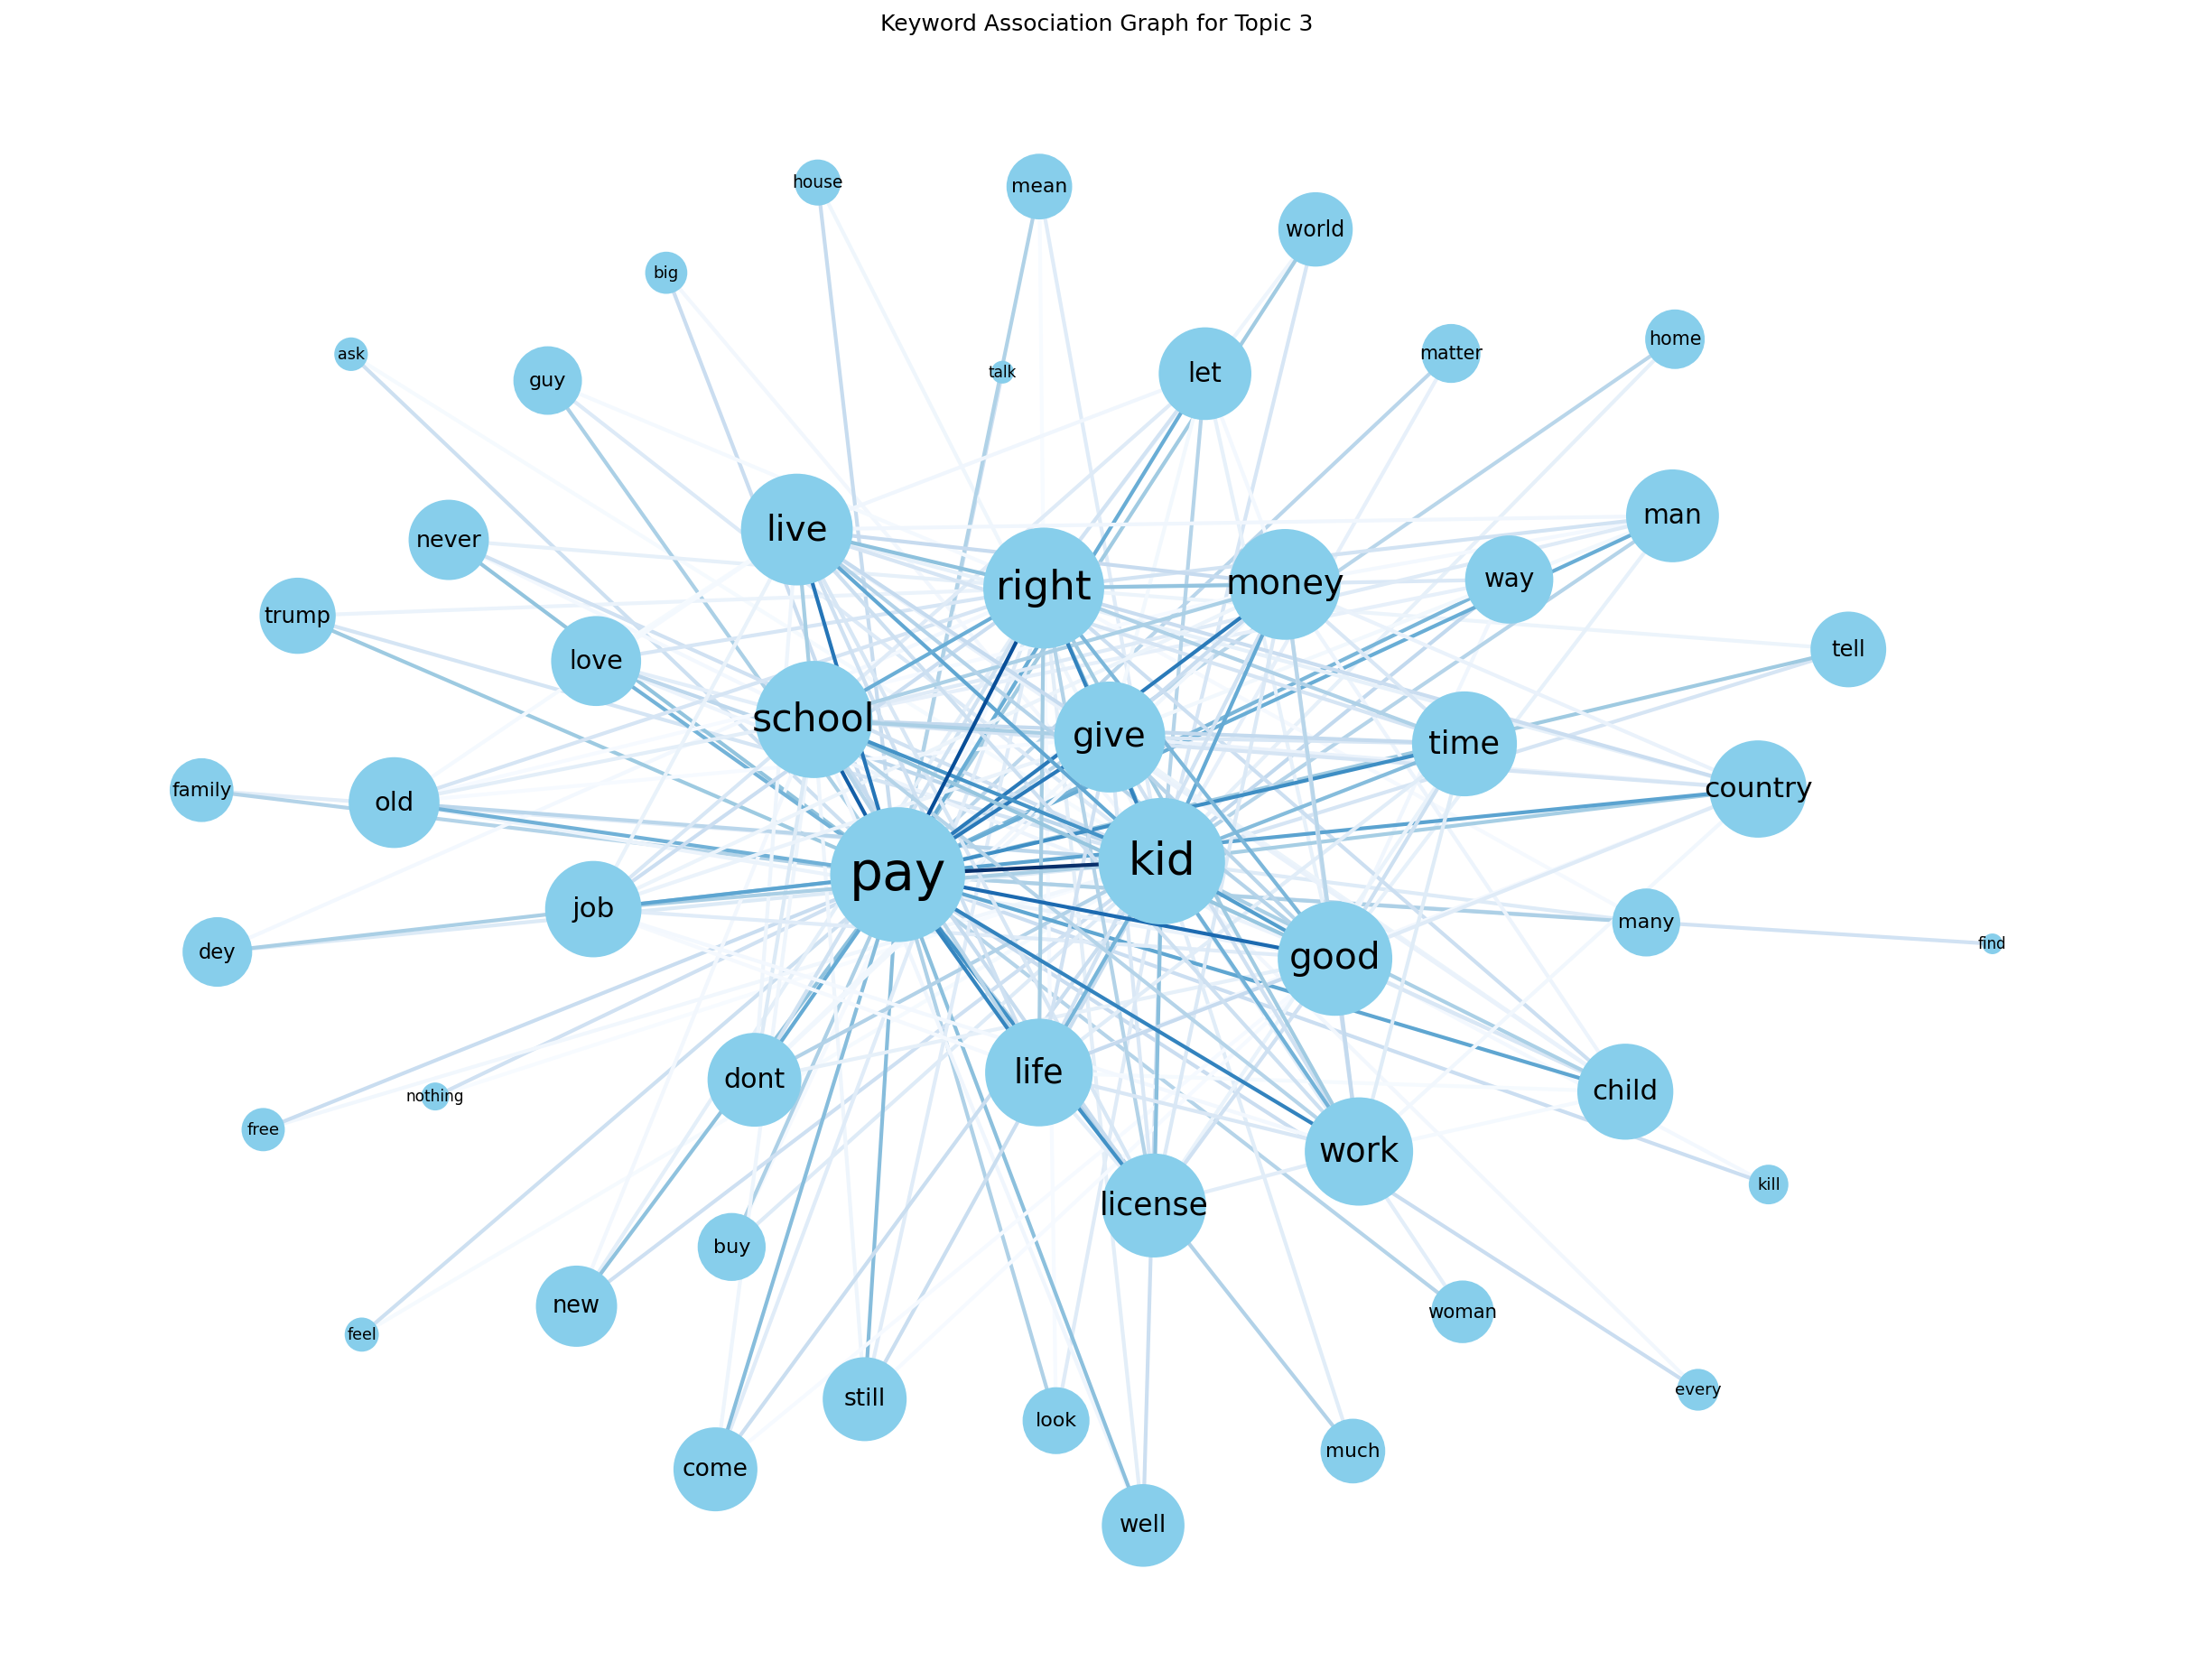

In [51]:
import networkx as nx
from collections import Counter

topic_idx = 2  # Topic 3
top_n = 50
top_keywords = [(feature_names[i], topics[topic_idx][i]) for i in topics[topic_idx].argsort()[-top_n:]]
words, weights = zip(*top_keywords)

G_topic = nx.Graph()

for word, weight in top_keywords:
    G_topic.add_node(word, size=weight)

for i in range(len(words)):
    for j in range(i + 1, len(words)):
        if words[i] != words[j]:
            if G_topic.has_edge(words[i], words[j]):
                G_topic[words[i]][words[j]]['weight'] += 1  
            else:
                G_topic.add_edge(words[i], words[j], weight=(weights[i] + weights[j]) / 2)  

edges_to_draw = [(u, v) for u, v in G_topic.edges() if G_topic[u][v]['weight'] > 600]

plt.figure(figsize=(16, 12), dpi=150)
pos = nx.spring_layout(G_topic, seed=42, k=0.7) 

min_node_size = 100
max_node_size = 5000
log_sizes = [np.log(G_topic.nodes[node]['size'] + 1) for node in G_topic.nodes()]  
min_log_size = min(log_sizes)
max_log_size = max(log_sizes)

node_sizes = [
    min_node_size + ((log_size - min_log_size) / (max_log_size - min_log_size)) * (max_node_size - min_node_size)
    for log_size in log_sizes
]

edge_weights = [G_topic[u][v]['weight'] for u, v in edges_to_draw]
min_weight = min(edge_weights)
max_weight = max(edge_weights)
edge_colors = [
    plt.cm.Blues((weight - min_weight) / (max_weight - min_weight)) for weight in edge_weights
]

nx.draw(
    G_topic, pos, edgelist=edges_to_draw, with_labels=False, node_color='skyblue',
    edge_color=edge_colors, node_size=node_sizes, width=2
)

font_size_base = 8
font_size_scaling = 20
for node, (x, y) in pos.items():
    node_size = G_topic.nodes[node]['size']
    font_size = font_size_base + ((node_size - min(weights)) / (max(weights) - min(weights))) * font_size_scaling
    plt.text(
        x, y, s=node, fontsize=font_size, color='black',
        horizontalalignment='center', verticalalignment='center'
    )

plt.title("Keyword Association Graph for Topic 3")
plt.show()

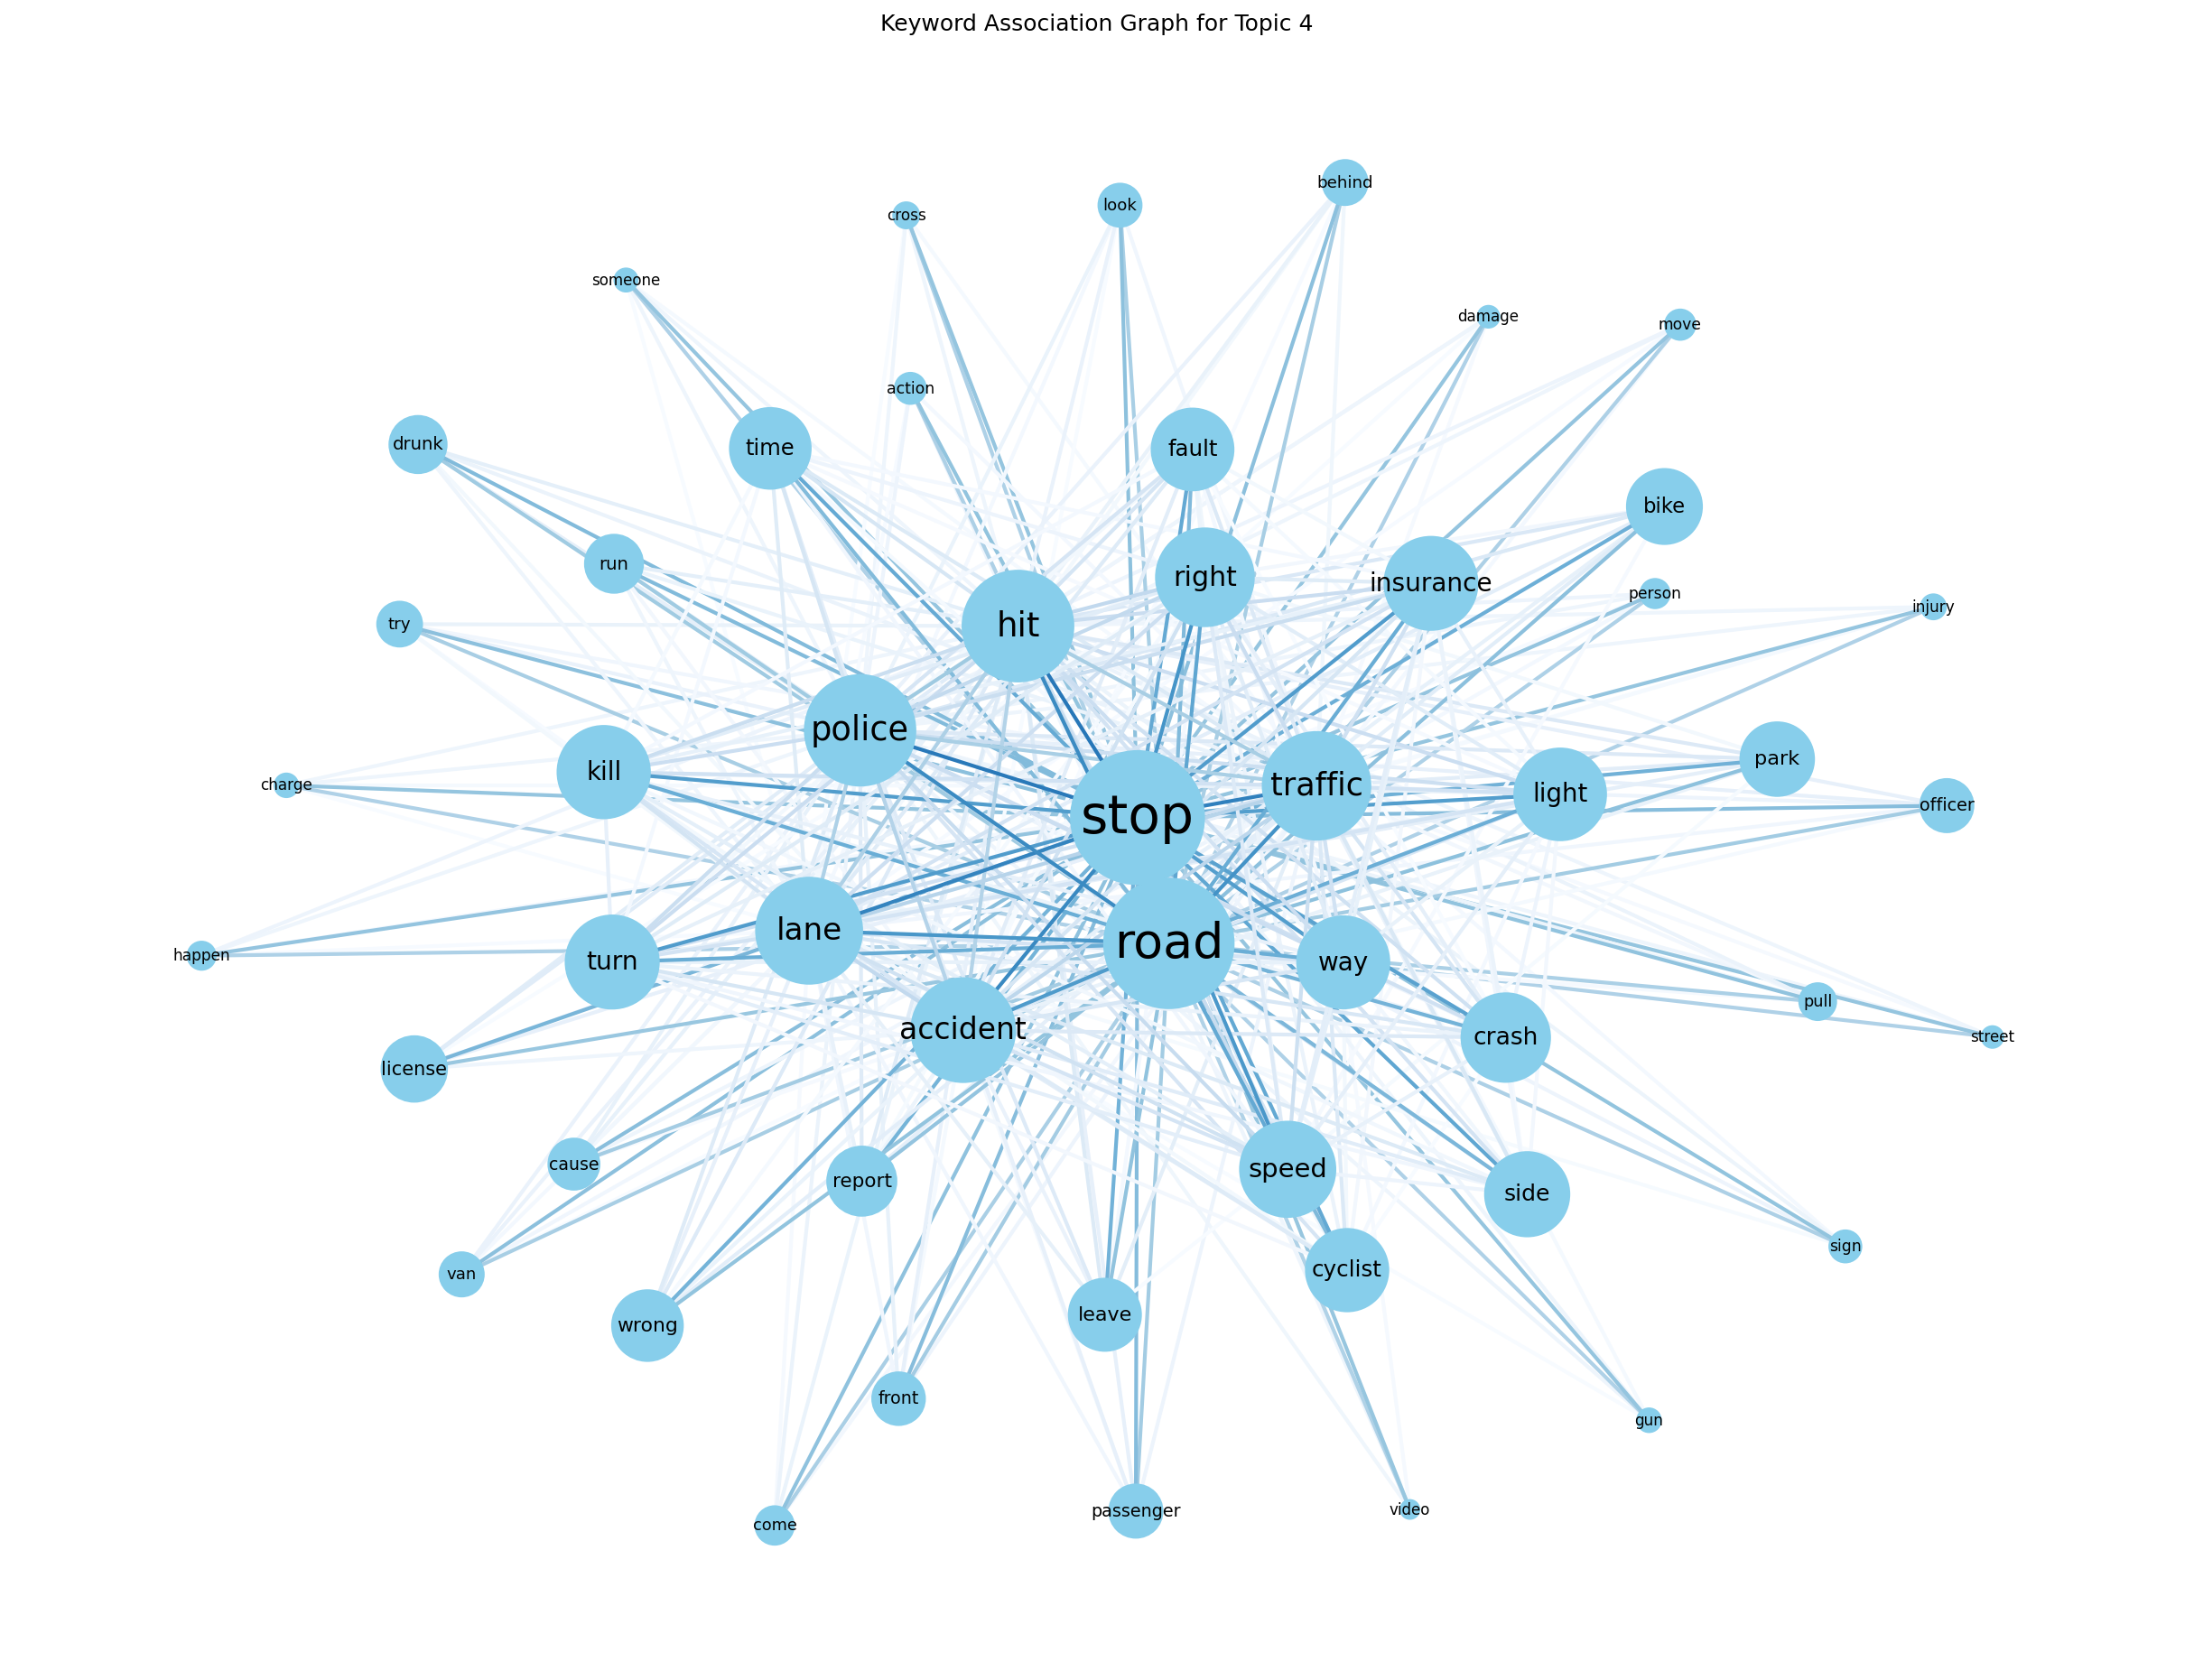

In [52]:
import networkx as nx
from collections import Counter

topic_idx = 3  # Topic 4
top_n = 50
top_keywords = [(feature_names[i], topics[topic_idx][i]) for i in topics[topic_idx].argsort()[-top_n:]]
words, weights = zip(*top_keywords)

G_topic = nx.Graph()

for word, weight in top_keywords:
    G_topic.add_node(word, size=weight)

for i in range(len(words)):
    for j in range(i + 1, len(words)):
        if words[i] != words[j]:
            if G_topic.has_edge(words[i], words[j]):
                G_topic[words[i]][words[j]]['weight'] += 1  
            else:
                G_topic.add_edge(words[i], words[j], weight=(weights[i] + weights[j]) / 2)  

edges_to_draw = [(u, v) for u, v in G_topic.edges() if G_topic[u][v]['weight'] > 800]

plt.figure(figsize=(16, 12), dpi=150)
pos = nx.spring_layout(G_topic, seed=42, k=0.7)  

min_node_size = 100
max_node_size = 5000
log_sizes = [np.log(G_topic.nodes[node]['size'] + 1) for node in G_topic.nodes()]  
min_log_size = min(log_sizes)
max_log_size = max(log_sizes)

node_sizes = [
    min_node_size + ((log_size - min_log_size) / (max_log_size - min_log_size)) * (max_node_size - min_node_size)
    for log_size in log_sizes
]

edge_weights = [G_topic[u][v]['weight'] for u, v in edges_to_draw]
min_weight = min(edge_weights)
max_weight = max(edge_weights)
edge_colors = [
    plt.cm.Blues((weight - min_weight) / (max_weight - min_weight)) for weight in edge_weights
]

nx.draw(
    G_topic, pos, edgelist=edges_to_draw, with_labels=False, node_color='skyblue',
    edge_color=edge_colors, node_size=node_sizes, width=2
)

font_size_base = 8
font_size_scaling = 20
for node, (x, y) in pos.items():
    node_size = G_topic.nodes[node]['size']
    font_size = font_size_base + ((node_size - min(weights)) / (max(weights) - min(weights))) * font_size_scaling
    plt.text(
        x, y, s=node, fontsize=font_size, color='black',
        horizontalalignment='center', verticalalignment='center'
    )

plt.title("Keyword Association Graph for Topic 4")
plt.show()

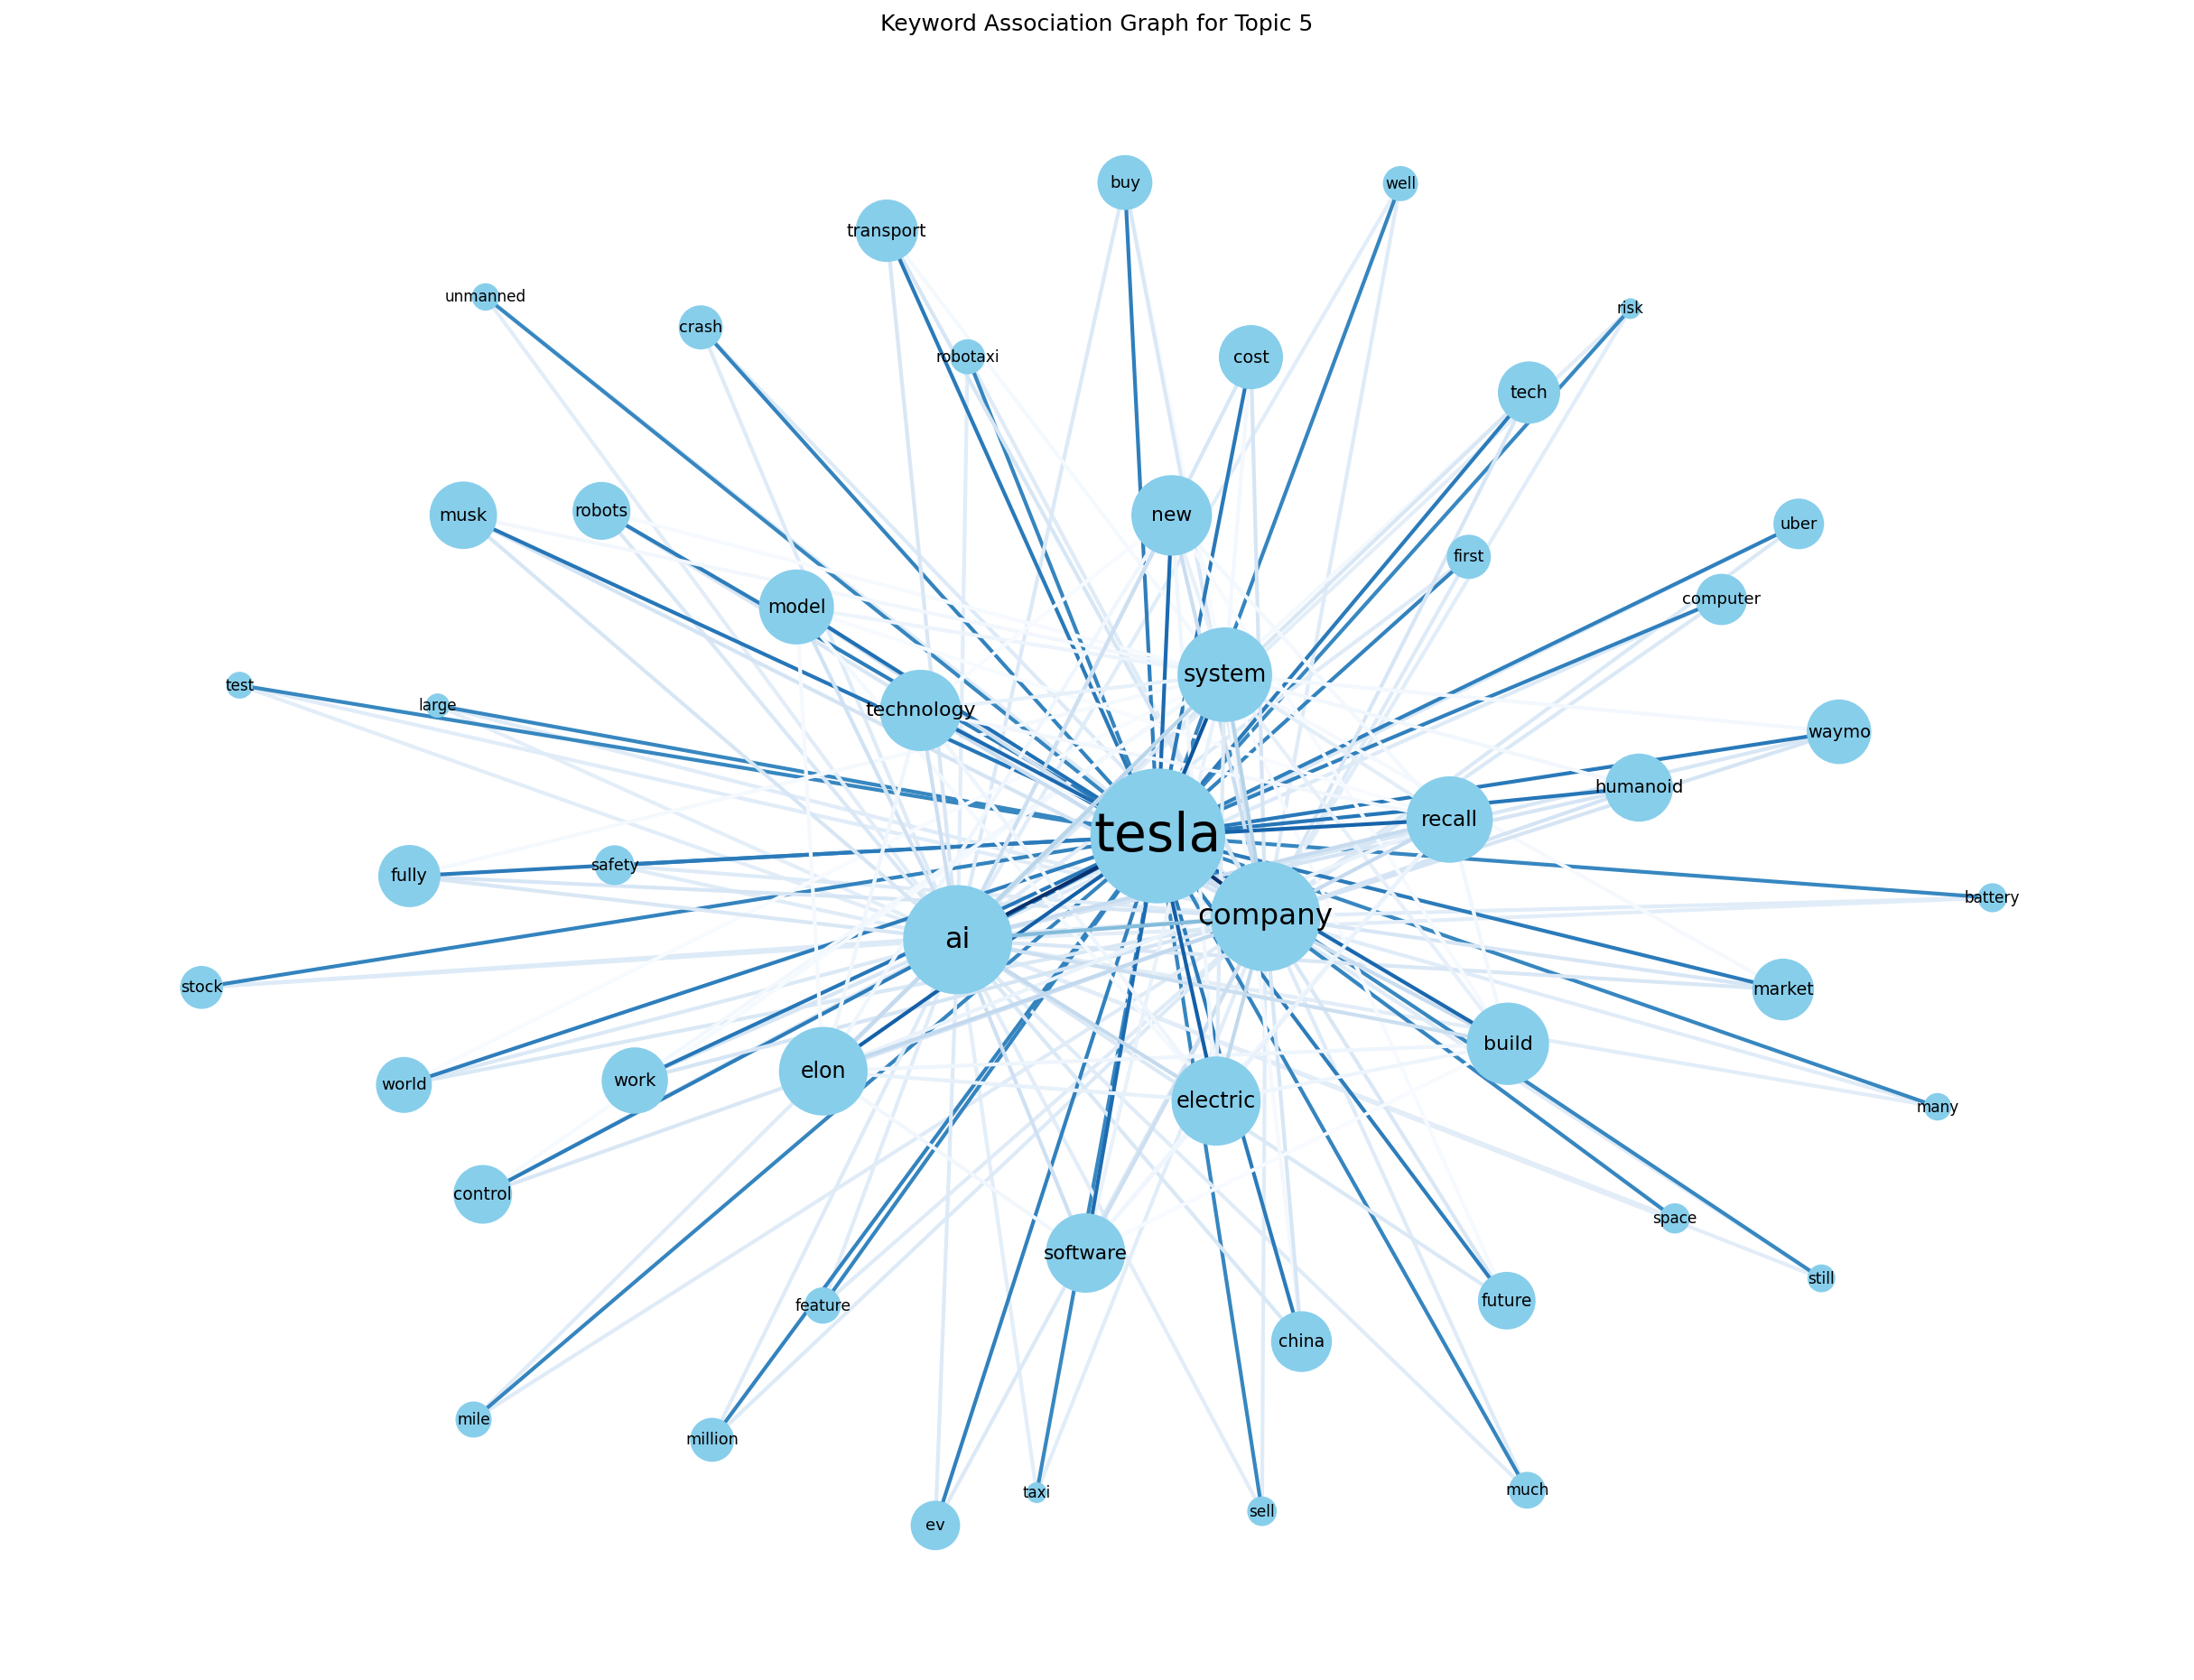

In [53]:
import networkx as nx
from collections import Counter

topic_idx = 4  # Topic 5
top_n = 50
top_keywords = [(feature_names[i], topics[topic_idx][i]) for i in topics[topic_idx].argsort()[-top_n:]]
words, weights = zip(*top_keywords)

G_topic = nx.Graph()

for word, weight in top_keywords:
    G_topic.add_node(word, size=weight)

for i in range(len(words)):
    for j in range(i + 1, len(words)):
        if words[i] != words[j]:
            if G_topic.has_edge(words[i], words[j]):
                G_topic[words[i]][words[j]]['weight'] += 1  
            else:
                G_topic.add_edge(words[i], words[j], weight=(weights[i] + weights[j]) / 2)  

edges_to_draw = [(u, v) for u, v in G_topic.edges() if G_topic[u][v]['weight'] > 600]

plt.figure(figsize=(16, 12), dpi=150)
pos = nx.spring_layout(G_topic, seed=42, k=0.5)  

min_node_size = 100
max_node_size = 5000
log_sizes = [np.log(G_topic.nodes[node]['size'] + 1) for node in G_topic.nodes()]  
min_log_size = min(log_sizes)
max_log_size = max(log_sizes)

node_sizes = [
    min_node_size + ((log_size - min_log_size) / (max_log_size - min_log_size)) * (max_node_size - min_node_size)
    for log_size in log_sizes
]

edge_weights = [G_topic[u][v]['weight'] for u, v in edges_to_draw]
min_weight = min(edge_weights)
max_weight = max(edge_weights)
edge_colors = [
    plt.cm.Blues((weight - min_weight) / (max_weight - min_weight)) for weight in edge_weights
]

nx.draw(
    G_topic, pos, edgelist=edges_to_draw, with_labels=False, node_color='skyblue',
    edge_color=edge_colors, node_size=node_sizes, width=2
)

font_size_base = 8
font_size_scaling = 20
for node, (x, y) in pos.items():
    node_size = G_topic.nodes[node]['size']
    font_size = font_size_base + ((node_size - min(weights)) / (max(weights) - min(weights))) * font_size_scaling
    plt.text(
        x, y, s=node, fontsize=font_size, color='black',
        horizontalalignment='center', verticalalignment='center'
    )

plt.title("Keyword Association Graph for Topic 5")
plt.show()